In [252]:
import numpy as np
import tensorflow as tf
import re
import string
import matplotlib.pyplot as plt

train_raw_ds = tf.keras.preprocessing.text_dataset_from_directory(
    directory='./data',
    validation_split=0.2, 
    subset='training',
    batch_size=8,
    shuffle=True,
    seed=123
)
test_raw_ds = tf.keras.preprocessing.text_dataset_from_directory(
    directory='./data',
    validation_split=0.2, 
    subset='validation',
    batch_size=8,
    shuffle=True,
    seed=123
)

Found 1200 files belonging to 3 classes.
Using 960 files for training.
Found 1200 files belonging to 3 classes.
Using 240 files for validation.


In [253]:
# Визначення
#    розміру словнику (vocab_size),
#    максимального розміру словнику (max_tokens)
def standardization(input_data):
    output = tf.strings.lower(input_data, encoding='utf-8')
    output = tf.strings.regex_replace(output, '[%s]' % re.escape(string.punctuation), '')
    output = tf.strings.regex_replace(output, '[%s]' % (b'\xc2\xa0'.decode() + b'\xe2\xa0\x80'.decode()), ' ')
    return output

def analyse_dataset(raw_ds):
    documents_ds = raw_ds.map(lambda x, y: x)
    words_ds = documents_ds.map(lambda document: tf.strings.split(standardization(document))).unbatch()
    vocab_ds = words_ds.flat_map(tf.data.Dataset.from_tensor_slices).apply(tf.data.experimental.unique())
    vocab_size = vocab_ds.reduce(0, lambda count, x: count + 1).numpy()
    return vocab_size
    
vocab_size = analyse_dataset(train_raw_ds)
max_tokens = vocab_size + 2
print('vocab_size:', vocab_size)
print('max_tokens:', max_tokens)

# Додавання шару векторизації тексту
def custom_text_vectorization_layer(raw_ds, max_tokens):
    documents_ds = raw_ds.map(lambda x, y: x)
    layer = tf.keras.layers.experimental.preprocessing.TextVectorization(
        standardize=standardization,
        max_tokens=max_tokens
    )
    layer.adapt(documents_ds)
    return layer
    
text_vect_layer = custom_text_vectorization_layer(train_raw_ds, max_tokens)
print('effective vocabulary size:', len(text_vect_layer.get_vocabulary()))

vocab_size: 20732
max_tokens: 20734
effective vocabulary size: 20734


In [232]:
print(f"Vocabulary: [{','.join(text_vect_layer.get_vocabulary()[50:60])}'...]")
# print(list(text_vect_layer(['только что вышел новый айфон']).numpy()))

Vocabulary: [при,black,видео,можете,как,5,можна,экран,к,дисплей'...]


In [260]:
# LSTM model
lstm = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    custom_text_vectorization_layer(train_raw_ds, max_tokens),
    tf.keras.layers.Embedding(max_tokens, 50, mask_zero=True),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(3, activation='softmax')
])
lstm.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
lstm.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_76 (TextV (None, None)              0         
_________________________________________________________________
embedding_66 (Embedding)     (None, None, 50)          1036700   
_________________________________________________________________
lstm_64 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_42 (Dense)             (None, 3)                 153       
Total params: 1,057,053
Trainable params: 1,057,053
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
120/120 [==============================] - 39s 328ms/step - loss: 0.8364 - acc: 0.6104 - val_loss: 0.5799 - val_acc: 0.6792
Epoch 2/10
120/120 [==============================] - 38s 320ms/step - loss: 0.2868 - acc: 0.9125 - val_loss: 0.3317 - val_acc: 0.9208
Epoch 3/10
120/120 [==============================] - 38s 317ms/step - loss: 0.0605 - acc: 0.9917 - val_loss: 0.1743 - val_acc: 0.9458
Epoch 4/10
120/120 [==============================] - 33s 274ms/step - loss: 0.0266 - acc: 0.9927 - val_loss: 0.1528 - val_acc: 0.9458
Epoch 5/10
120/120 [==============================] - 29s 244ms/step - loss: 0.0209 - acc: 0.9937 - val_loss: 0.1405 - val_acc: 0.9583
Epoch 6/10
120/120 [==============================] - 33s 274ms/step - loss: 0.0174 - acc: 0.9937 - val_loss: 0.1542 - val_acc: 0.9583
Epoch 7/10
120/120 [==============================] - 39s 325ms/step - loss: 0.0221 - acc: 0.9927 - val_loss: 0.1613 - val_acc: 0.9500
Epoch 8/10
120/120 [==============================] - 4

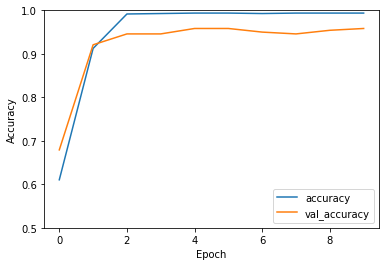

In [261]:
history = lstm.fit(
    train_raw_ds,
    validation_data=test_raw_ds, 
    epochs=10
)

plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

In [264]:
# LSTM model
lstm = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    custom_text_vectorization_layer(train_raw_ds, max_tokens),
    tf.keras.layers.Embedding(max_tokens, 25, mask_zero=True),
    tf.keras.layers.LSTM(25),
    tf.keras.layers.Dense(3, activation='softmax')
])
lstm.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
lstm.summary()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_78 (TextV (None, None)              0         
_________________________________________________________________
embedding_68 (Embedding)     (None, None, 25)          518350    
_________________________________________________________________
lstm_66 (LSTM)               (None, 25)                5100      
_________________________________________________________________
dense_44 (Dense)             (None, 3)                 78        
Total params: 523,528
Trainable params: 523,528
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
120/120 [==============================] - 32s 266ms/step - loss: 0.8841 - acc: 0.5927 - val_loss: 0.7088 - val_acc: 0.6917
Epoch 2/10
120/120 [==============================] - 29s 242ms/step - loss: 0.4751 - acc: 0.8573 - val_loss: 0.2753 - val_acc: 0.9042
Epoch 3/10
120/120 [==============================] - 37s 310ms/step - loss: 0.1882 - acc: 0.9594 - val_loss: 0.1950 - val_acc: 0.9458
Epoch 4/10
120/120 [==============================] - 28s 230ms/step - loss: 0.0681 - acc: 0.9844 - val_loss: 0.1214 - val_acc: 0.9625
Epoch 5/10
120/120 [==============================] - 26s 220ms/step - loss: 0.0430 - acc: 0.9885 - val_loss: 0.1458 - val_acc: 0.9542
Epoch 6/10
120/120 [==============================] - 34s 282ms/step - loss: 0.0398 - acc: 0.9875 - val_loss: 0.1293 - val_acc: 0.9583
Epoch 7/10
120/120 [==============================] - 34s 285ms/step - loss: 0.0245 - acc: 0.9906 - val_loss: 0.1319 - val_acc: 0.9583
Epoch 8/10
120/120 [==============================] - 3

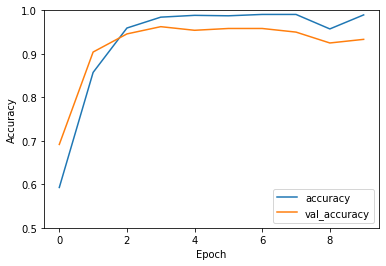

In [265]:
history = lstm.fit(
    train_raw_ds,
    validation_data=test_raw_ds, 
    epochs=10
)

plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

In [266]:
# LSTM model
lstm = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    custom_text_vectorization_layer(train_raw_ds, max_tokens),
    tf.keras.layers.Embedding(max_tokens, 50, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(25)),
    tf.keras.layers.Dense(3, activation='softmax')
])
lstm.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
lstm.summary()

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_79 (TextV (None, None)              0         
_________________________________________________________________
embedding_69 (Embedding)     (None, None, 50)          1036700   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50)                15200     
_________________________________________________________________
dense_45 (Dense)             (None, 3)                 153       
Total params: 1,052,053
Trainable params: 1,052,053
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
120/120 [==============================] - 47s 392ms/step - loss: 0.7275 - acc: 0.7156 - val_loss: 0.3448 - val_acc: 0.8708
Epoch 2/10
120/120 [==============================] - 40s 329ms/step - loss: 0.1321 - acc: 0.9698 - val_loss: 0.1631 - val_acc: 0.9375
Epoch 3/10
120/120 [==============================] - 45s 376ms/step - loss: 0.0599 - acc: 0.9896 - val_loss: 0.1658 - val_acc: 0.9333
Epoch 4/10
120/120 [==============================] - 44s 363ms/step - loss: 0.0294 - acc: 0.9927 - val_loss: 0.1497 - val_acc: 0.9458
Epoch 5/10
120/120 [==============================] - 42s 350ms/step - loss: 0.0306 - acc: 0.9896 - val_loss: 0.1394 - val_acc: 0.9375
Epoch 6/10
120/120 [==============================] - 48s 401ms/step - loss: 0.0192 - acc: 0.9937 - val_loss: 0.1398 - val_acc: 0.9500
Epoch 7/10
120/120 [==============================] - 44s 369ms/step - loss: 0.0164 - acc: 0.9937 - val_loss: 0.1406 - val_acc: 0.9500
Epoch 8/10
120/120 [==============================] - 4

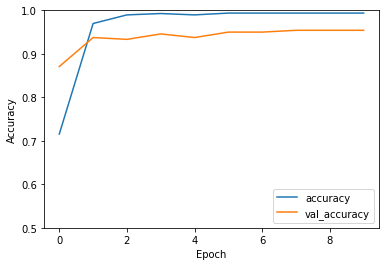

In [267]:
history = lstm.fit(
    train_raw_ds,
    validation_data=test_raw_ds, 
    epochs=10
)

plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

In [268]:
# LSTM model
lstm = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    custom_text_vectorization_layer(train_raw_ds, max_tokens),
    tf.keras.layers.Embedding(max_tokens, 50, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
    tf.keras.layers.Dense(3, activation='softmax')
])
lstm.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
lstm.summary()

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_80 (TextV (None, None)              0         
_________________________________________________________________
embedding_70 (Embedding)     (None, None, 50)          1036700   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100)               40400     
_________________________________________________________________
dense_46 (Dense)             (None, 3)                 303       
Total params: 1,077,403
Trainable params: 1,077,403
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
120/120 [==============================] - 49s 407ms/step - loss: 0.6458 - acc: 0.7510 - val_loss: 0.2776 - val_acc: 0.9000
Epoch 2/10
120/120 [==============================] - 49s 408ms/step - loss: 0.1045 - acc: 0.9760 - val_loss: 0.1404 - val_acc: 0.9667
Epoch 3/10
120/120 [==============================] - 47s 394ms/step - loss: 0.0329 - acc: 0.9917 - val_loss: 0.0605 - val_acc: 0.9667
Epoch 4/10
120/120 [==============================] - 49s 408ms/step - loss: 0.0247 - acc: 0.9937 - val_loss: 0.0763 - val_acc: 0.9708
Epoch 5/10
120/120 [==============================] - 43s 360ms/step - loss: 0.0169 - acc: 0.9937 - val_loss: 0.0984 - val_acc: 0.9667
Epoch 6/10
120/120 [==============================] - 45s 374ms/step - loss: 0.0158 - acc: 0.9937 - val_loss: 0.0775 - val_acc: 0.9667
Epoch 7/10
120/120 [==============================] - 46s 383ms/step - loss: 0.0149 - acc: 0.9927 - val_loss: 0.0568 - val_acc: 0.9875
Epoch 8/10
120/120 [==============================] - 4

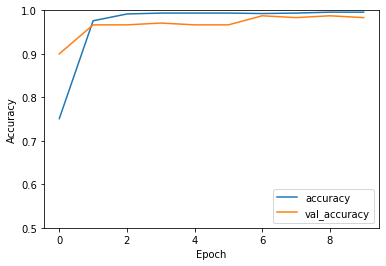

In [269]:
history = lstm.fit(
    train_raw_ds,
    validation_data=test_raw_ds, 
    epochs=10
)

plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()